### Task 3: Customer Segmentation / Clustering

Perform **customer segmentation** using clustering techniques. Use both **profile information** (from `Customers.csv`) and **transaction information** (from `Transactions.csv`).

#### Requirements:
- You have the flexibility to choose any clustering algorithm and any number of clusters between **2 and 10**.
- Calculate clustering metrics, including the **DB Index** (Evaluation will be done on this).
- Visualize your clusters using relevant plots.

#### Deliverables:
1. **A report** on your clustering results, including:
   - The **number of clusters** formed.
   - **DB Index value**.
   - Other relevant clustering metrics.
2. A **Jupyter Notebook/Python script** containing your clustering code.

#### Evaluation Criteria:
- **Clustering logic and metrics**: Ensure the chosen algorithm and approach make sense for the problem.
- **Visual representation of clusters**: Provide clear and informative plots that showcase the results of your clustering process.


# Load the datasets

In [58]:
import pandas as pd

# Load the datasets
df_customers  = pd.read_csv('/content/Customers.csv')
df_products = pd.read_csv('/content/Products.csv')
df_transactions = pd.read_csv('/content/Transactions.csv')

Display the first few rows and the data types for each DataFrame

In [59]:
print("Customers Data:")
print(df_customers.dtypes)
df_customers.head()

Customers Data:
CustomerID      object
CustomerName    object
Region          object
SignupDate      object
dtype: object


,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [60]:
print("\nProducts Data:")
print(df_products.dtypes)
df_products.head()


Products Data:
ProductID       object
ProductName     object
Category        object
Price          float64
dtype: object


,ProductID,ProductName,Category,Price
0,P001,ActiveWear Biography,Books,169.30
1,P002,ActiveWear Smartwatch,Electronics,346.30
2,P003,ComfortLiving Biography,Books,44.12
3,P004,BookWorld Rug,Home Decor,95.69
4,P005,TechPro T-Shirt,Clothing,429.31


In [61]:
print("\nTransactions Data:")
print(df_transactions.dtypes)
df_transactions.head()


Transactions Data:
TransactionID       object
CustomerID          object
ProductID           object
TransactionDate     object
Quantity             int64
TotalValue         float64
Price              float64
dtype: object


,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


In [62]:
# Merge transactions with product
df_merged = pd.merge(df_transactions, df_products, on='ProductID', how='left')

# Merge with customer info
df_merged = pd.merge(df_merged, df_customers, on='CustomerID', how='left')

In [63]:
# Inspect the merged DataFrame
print("Merged DataFrame Shape:", df_merged.shape)
df_merged.head()

Merged DataFrame Shape: (1000, 13)


,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,ProductName,Category,Price_y,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Timothy Perez,Europe,2022-03-15


##Feature Engineering

 Group by CustomerID to get total spend, total quantity, transaction count

In [64]:
customer_features = df_merged.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'TransactionID': 'count'  # counting number of transactions
}).reset_index()

In [65]:
customer_features.columns = ['CustomerID', 'TotalSpend', 'TotalQuantity', 'TransactionCount']


customer_segment_data = pd.merge(customer_features, df_customers[['CustomerID', 'Region']], on='CustomerID')


customer_segment_data = pd.get_dummies(customer_segment_data, columns=['Region'], drop_first=True)

# Inspect final features
customer_segment_data.head()

,CustomerID,TotalSpend,TotalQuantity,TransactionCount,Region_Europe,Region_North America,Region_South America
0,C0001,3354.52,12,5,False,False,True
1,C0002,1862.74,10,4,False,False,False
2,C0003,2725.38,14,4,False,False,True
3,C0004,5354.88,23,8,False,False,True
4,C0005,2034.24,7,3,False,False,False


##Data Cleaning and Scaling

Handle missing values and apply scaling so that features are on a comparable scale.

In [66]:
from sklearn.preprocessing import StandardScaler


customer_segment_data.fillna(0, inplace=True)

# Select numeric columns for clustering
numeric_cols = ['TotalSpend', 'TotalQuantity', 'TransactionCount'] + \
    [col for col in customer_segment_data.columns if col.startswith('Region_')]

In [67]:
# Scale features
scaler = StandardScaler()
customer_segment_data_scaled = scaler.fit_transform(customer_segment_data[numeric_cols])

##Clustering (Example Using K-Means)

In [68]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

X = customer_segment_data_scaled

db_scores = {}
for k in range(2, 11):  # from 2 to 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    db_index = davies_bouldin_score(X, labels)
    db_scores[k] = db_index
    print(f"Clusters: {k}, DB Index: {db_index:.4f}")

Clusters: 2, DB Index: 1.4494
Clusters: 3, DB Index: 1.1989
Clusters: 4, DB Index: 0.9881
Clusters: 5, DB Index: 0.9385
Clusters: 6, DB Index: 0.9080
Clusters: 7, DB Index: 0.9603
Clusters: 8, DB Index: 0.8371
Clusters: 9, DB Index: 0.7919
Clusters: 10, DB Index: 0.7900


In [69]:
# Choose the best k based on the lowest Davies-Bouldin Index
best_k = min(db_scores, key=db_scores.get)
print(f"\nBest number of clusters based on DB Index: {best_k}")


Best number of clusters based on DB Index: 10


##Final Clustering and Results

In [70]:
kmeans_best = KMeans(n_clusters=best_k, random_state=42)
final_labels = kmeans_best.fit_predict(X)

# Attach cluster labels to the original DataFrame
customer_segment_data['Cluster'] = final_labels

In [71]:
# Calculate final DB index for your chosen k
final_db_index = davies_bouldin_score(X, final_labels)
f"Final DB Index with {best_k} clusters: {final_db_index:.4f}"

'Final DB Index with 10 clusters: 0.7900'

In [72]:
# Example cluster counts
customer_segment_data['Cluster'].value_counts()

,count
Cluster,
1,35
3,27
6,26
2,26
8,24
7,19
5,18
9,13
4,7


##Visualization

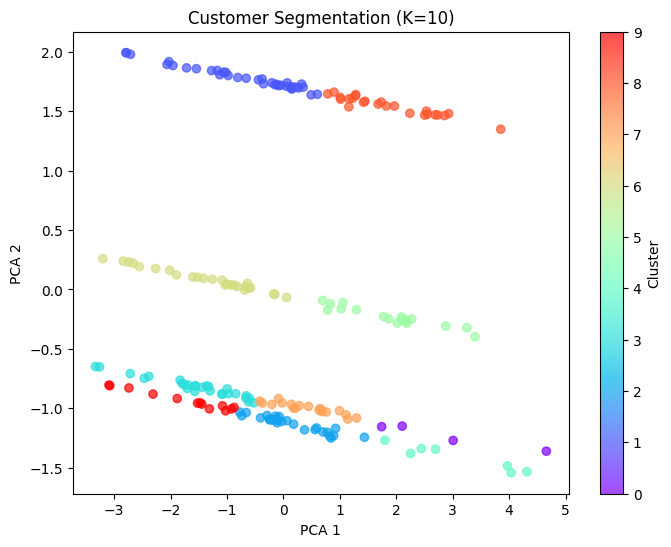

In [73]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1],
                      c=final_labels, cmap='rainbow', alpha=0.7)
plt.title(f'Customer Segmentation (K={best_k})')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(scatter, label='Cluster')
plt.show()

###Summary

- Read and merge the data from the three CSV files into a single DataFrame.

- Create customer-level features (e.g., total spend, transaction count), possibly augmented by product information and region.

- Clean, scale, and transform your feature set.

- Use clustering algorithms (e.g., K-Means) to segment your customers.

- Evaluate the clustering with metrics like Davies-Bouldin Index (DB Index).

- Visualize the results (e.g., PCA scatter plots) and summarize insights.

- This approach provides a full pipeline for customer segmentation using clustering on the eCommerce dataset.

- Feel free to adjust feature engineering steps,We can try different clustering methods (e.g., DBSCAN, Agglomerative Clustering), or refine visuals and metrics based on your specific analysis goals.
